# DATA PREPROCESSING:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORT ALL LIBRARIES:

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate, add



Listing of all train and test images:

In [ ]:
train_list=os.listdir('/content/drive/MyDrive/cityscapes_data/train')
test_list=os.listdir('/content/drive/MyDrive/cityscapes_data/val')

In [ ]:
train_list=['/content/drive/MyDrive/cityscapes_data/train/'+i for i in train_list]
test_list=['/content/drive/MyDrive/cityscapes_data/val/'+i for i in test_list]

## Load image:

In [ ]:
def load_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X=img[:,:256,:]
    Y=img[:,256:,:]
    return X,Y

## ASSIGN CLASS LABELS USING KMEANS FOR SEGMENTED IMAGES:

In [ ]:
from tqdm import tqdm
colors=[]

for i in tqdm(range(200)):
    x,y=load_image(train_list[i])
    colors.append(y.reshape(y.shape[0]*y.shape[1],3))

100%|██████████| 200/200 [00:10<00:00, 19.81it/s] 


In [ ]:
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))
print(colors.shape)

(13107200, 3)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=13, random_state=0)
kmeans.fit(colors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=13, random_state=0)

In [ ]:
def mask_to_labels(mask):
    masked=mask.reshape((mask.shape[0]*mask.shape[1],3))
    pred=kmeans.predict(masked)
    pred=pred.reshape(mask.shape[0],mask.shape[1])

    cls = np.zeros((mask.shape[0], mask.shape[1], 13))

    for i in range(13):
        cls[:, :, i] = (pred == i ).astype(int)


    return cls

## LOADING DATA FOR TRAINING USING DATA GENERATOR:

In [ ]:
def data_generator(path, batch_size=10):
    while True:
        for i in range(0, len(path), batch_size):
            batch_files = path[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = load_image(file)


                imgs.append(image)
                segs.append(mask_to_labels(mask))

            yield np.array(imgs), np.array(segs)

In [ ]:
train_gen=data_generator(train_list)
valid_gen=data_generator(test_list)

# SEGNET MODEL ARCHITECTURE:

In [ ]:
def segnet():

    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)

    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3)

    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4)

    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5)



    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)

    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)


    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)

    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)


    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)


    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3)

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)


    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3)

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)


    output=Conv2D(13,(1,1),activation='softmax')(batch2)

    model=Model(input1,output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
    return model

In [ ]:
segnet_model=segnet()

# TRAINING SEGNET MODEL:

In [ ]:
segnet_model.fit_generator(train_gen,steps_per_epoch=len(train_list) // 10,
        epochs=20,
        validation_data=valid_gen,
        validation_steps=len(test_list)//10)

<ipython-input-19-eb5fd005c8ae>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  segnet_model.fit_generator(train_gen,steps_per_epoch=len(train_list) // 10,


Epoch 1/20
43/43 [==============================] - 362s 7s/step - loss: 1.3302 - accuracy: 0.6122 - val_loss: 1386194.8750 - val_accuracy: 0.1423
Epoch 2/20
43/43 [==============================] - 79s 1s/step - loss: 0.9750 - accuracy: 0.7053 - val_loss: 437.5466 - val_accuracy: 0.1794
Epoch 3/20
43/43 [==============================] - 64s 1s/step - loss: 0.9070 - accuracy: 0.7284 - val_loss: 72.7788 - val_accuracy: 0.1234
Epoch 4/20
43/43 [==============================] - 59s 1s/step - loss: 0.8632 - accuracy: 0.7410 - val_loss: 29.8625 - val_accuracy: 0.2431
Epoch 5/20
43/43 [==============================] - 68s 2s/step - loss: 0.8390 - accuracy: 0.7442 - val_loss: 6.2105 - val_accuracy: 0.3760
Epoch 6/20
43/43 [==============================] - 68s 2s/step - loss: 0.8279 - accuracy: 0.7505 - val_loss: 3.3199 - val_accuracy: 0.4631
Epoch 7/20
43/43 [==============================] - 68s 2s/step - loss: 0.8016 - accuracy: 0.7573 - val_loss: 2.3566 - val_accuracy: 0.4800
Epoch 8/2

## CONVERT PREDICTED CLASSES OUTPUT INTO IMAGE:

In [ ]:
def classes_to_colors(pred):
    pred=np.array(pred).reshape((256,256,13))
    pred=np.argmax(pred,axis=2)

    mask=np.zeros((256,256,3))
    for i in range(13):
        ind=np.where(pred==i)
        mask[ind[0],ind[1],:]=kmeans.cluster_centers_[i]
    return mask


# SAVE AND LOAD MODEL

In [ ]:
segnet_model.save('/content/drive/MyDrive/segnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
segnet_model=keras.models.load_model('/content/drive/MyDrive/segnet_model.h5')

**Grad Cam++ Explainability for Semantic Segmentation**

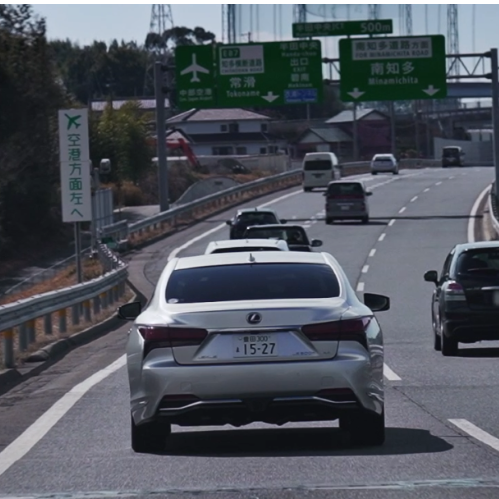

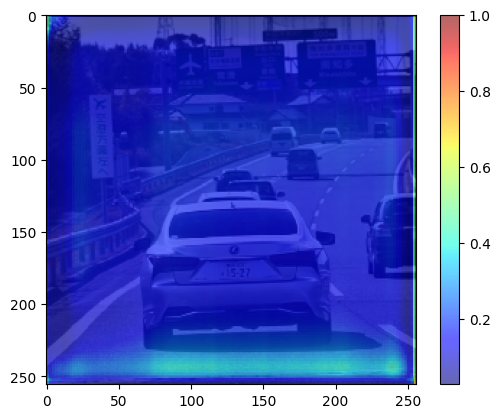

In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from tensorflow.keras.preprocessing import image

IMG_SIZE = (256, 256)

def vectorize_image(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return tf.cast(x, tf.float32) / (tf.sqrt(tf.reduce_mean(tf.square(x))) + 1e-5)

def get_gradcam_plus_plus(img_array, model, last_conv_layer_name):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[..., 0]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    gate_f = tf.cast(last_conv_layer_output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_r * gate_f * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)
    cam = np.maximum(cam, 0)

    heatmap = cam / np.max(cam)

    return heatmap


image_path = '/content/drive/MyDrive/Gradtest.png'
display(Image(image_path))


vectorized_image = vectorize_image(image_path, size=IMG_SIZE)


normalized_image = normalize(vectorized_image)


heatmap = get_gradcam_plus_plus(normalized_image, segnet_model, "conv2d_28")


heatmap = heatmap[0]


plt.imshow(vectorized_image[0]/255.0)
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.colorbar()
plt.show()
